In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import csv 
import sklearn
import pandas as pd
from sklearn import model_selection
from sklearn import metrics
from sklearn import neural_network
from sklearn import preprocessing
from sklearn import datasets
import warnings
import time
#warnings.filterwarnings('ignore')

In [2]:
#This is how I generated the dataset from the original MNIST dataset

#df1 = pd.read_csv("mnist_train.csv")
#df2 = df1.sample(frac=.1, random_state=42).reset_index(drop=True)
#
#y = df2["label"].values
#X = df2.iloc[:, 1:].values
#Xt = X.reshape(-1, 28, 28)
#X = ((Xt[:, ::2, ::2] + Xt[:, 1::2, ::2] + Xt[:, ::2, 1::2] + Xt[:, 1::2, 1::2]) / 4).reshape(-1, 14*14)
#labels = ["label"] + ["{}x{}".format(i, j) for i in range(14) for j in range(14)]
#df = pd.DataFrame(np.c_[(y, X)].astype(int), columns=labels)
#df.to_csv("digits.csv", index=False)

In [3]:
df = pd.read_csv("digits.csv")
X = df.iloc[:, 1:].values
y = df["label"].values
df.head()

,label,0x0,0x1,0x2,0x3,0x4,0x5,0x6,0x7,0x8,...,13x4,13x5,13x6,13x7,13x8,13x9,13x10,13x11,13x12,13x13
0,7,0,0,0,0,0,0,0,0,0,...,0,0,41,88,3,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


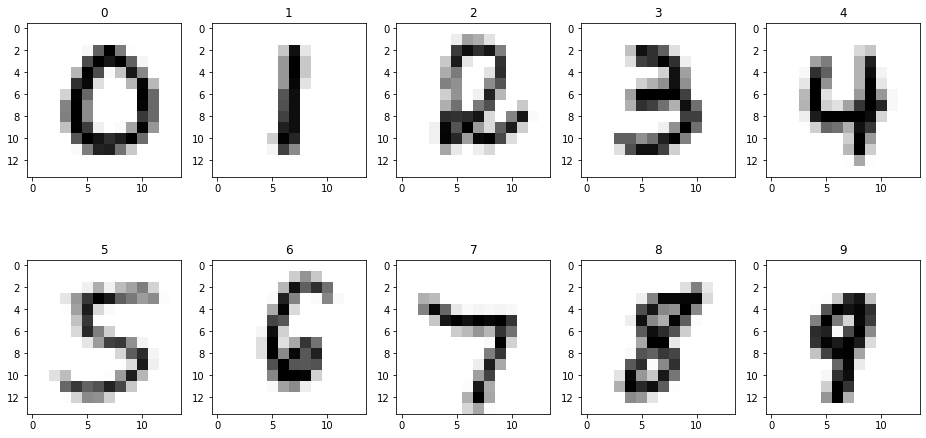

In [4]:
fig = plt.figure(figsize=(16,8))

for i in range(10):
    for j in range(y.shape[0]):
        if y[j] == i:
            ax = fig.add_subplot(2, 5, i+1)
            ax.imshow(X[j].reshape(14, 14), cmap=plt.cm.gray_r)
            ax.set_title(str(i))
            break

In [5]:
def eval_one(X, y, model, version="", scaler=None):
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        
    f1, precision, recall, ts, niters = [], [], [], [], []
    for train_index, test_index in kf.split(X):    
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #scaler = preprocessing.StandardScaler()
        if scaler:
            X_train = scaler.fit(X_train).transform(X_train)
        
        t = time.time()
        model.fit(X_train, y_train)
        t = time.time() - t
        
        if scaler:
            X_test = scaler.transform(X_test)
        
        y_pred = model.predict(X_test)
        f1 += [metrics.f1_score(y_test, y_pred, average="macro")]
        precision += [metrics.precision_score(y_test, y_pred, average="macro")]
        recall += [metrics.recall_score(y_test, y_pred, average="macro")]
        ts += [t]
        niters += [model.n_iter_]
        #print("{}:{}:{}".format(y_test.sum(), y_pred.sum(), len(y_test)))
        
   
    if scaler:
        mm = preprocessing.MinMaxScaler().get_params()["feature_range"]
    else:
        mm = "None"
        
    print("{}:{}:{}:\n    prec={} +/-{}\n    recall={} +/-{}\n    f1={} +/-{}".format(
        model.__class__.__name__, version, mm,
        np.mean(precision), np.std(precision),
        np.mean(recall), np.std(recall),
        np.mean(f1), np.std(f1)))
   
    nn = sum(c.flatten().shape[0] for c in model.coefs_)
    # -2 on layers b/c of input/output layers
    return {"layers": model.n_layers_ - 2,  "size": model.coefs_[0].shape[1], 
            "act": model.activation, "scale": mm, "f1": np.mean(f1), "nn": nn,
            "iter": np.max(niters), "t": np.mean(ts)}

    return np.mean(f1), np.mean(ts), np.max(niters)

In [6]:
data = []
for s in [20, 100]:
    for n in [2, 5]:
        layers = [s] * n

        for act in ["tanh", "relu"]:
            #(-1, 1),
            for mm in [(0, 1), None]:
                
                model = neural_network.MLPClassifier(activation=act, hidden_layer_sizes=layers, 
                                                     max_iter=1000, solver='lbfgs')
                if mm:
                    scaler = preprocessing.MinMaxScaler(mm)
                else:
                    scaler = None

                result = eval_one(X, y, model, "{},{}".format(act, layers), scaler=scaler)
                data += [result]

df_all = pd.DataFrame(data)
df_all

MLPClassifier:tanh,[20, 20]:(0, 1):
    prec=0.907230769159793 +/-0.0035830460115118296
    recall=0.9076851364504834 +/-0.003352182962092695
    f1=0.907077033623102 +/-0.0033853502284644883


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWa

MLPClassifier:tanh,[20, 20]:None:
    prec=0.8668822229073436 +/-0.011245036529454697
    recall=0.867650449904993 +/-0.011725068305474975
    f1=0.8666624791637834 +/-0.011441795300530393
MLPClassifier:relu,[20, 20]:(0, 1):
    prec=0.9056375753022212 +/-0.011479050411213469
    recall=0.9057970013474895 +/-0.012197712174765766
    f1=0.9050797020533942 +/-0.011877610488525191


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWa

MLPClassifier:relu,[20, 20]:None:
    prec=0.8212134647566574 +/-0.05318266584769712
    recall=0.8166762597788884 +/-0.0556961871716267
    f1=0.8147937017448381 +/-0.05814580209787685
MLPClassifier:tanh,[20, 20, 20, 20, 20]:(0, 1):
    prec=0.9117372809245676 +/-0.006209005289174459
    recall=0.9126850113879224 +/-0.007454218166889059
    f1=0.9115832902676739 +/-0.006806248298147588


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWa

MLPClassifier:tanh,[20, 20, 20, 20, 20]:None:
    prec=0.8322407399256534 +/-0.020307222709416935
    recall=0.8293502065817309 +/-0.02097487958742582
    f1=0.8288075688261618 +/-0.02049595605615054
MLPClassifier:relu,[20, 20, 20, 20, 20]:(0, 1):
    prec=0.9042096811986013 +/-0.009017528039974182
    recall=0.9045241850745793 +/-0.009056292110376498
    f1=0.9037887878472126 +/-0.008836217048598369


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier:relu,[20, 20, 20, 20, 20]:None:
    prec=0.8619234523167849 +/-0.016463986091721738
    recall=0.8626634793517747 +/-0.015939588717713157
    f1=0.8613767087724629 +/-0.016375398988239684
MLPClassifier:tanh,[100, 100]:(0, 1):
    prec=0.9357092303020123 +/-0.007445869121567257
    recall=0.9359029089719527 +/-0.006985074619004704
    f1=0.9354093816428047 +/-0.007234519649019815
MLPClassifier:tanh,[100, 100]:None:
    prec=0.9167791505402934 +/-0.004055957958892049
    recall=0.9166353839193583 +/-0.0044148283227220765
    f1=0.9163411361941218 +/-0.004246374091381742
MLPClassifier:relu,[100, 100]:(0, 1):
    prec=0.9308559416989096 +/-0.005222108958931374
    recall=0.9304813113614012 +/-0.005182601455102334
    f1=0.9303761661870832 +/-0.005226051365015195
MLPClassifier:relu,[100, 100]:None:
    prec=0.9173216591494153 +/-0.007935552975925202
    recall=0.9170284200678898 +/-0.007636859130777442
    f1=0.916801471676148 +/-0.007871449941978666
MLPClassifier:tanh,[100, 1

,layers,size,act,scale,f1,nn,iter,t
0,2,20,tanh,"(0, 1)",0.907077,4520,102,1.216603
1,2,20,tanh,None,0.866662,4520,1000,16.116372
2,2,20,relu,"(0, 1)",0.905080,4520,338,2.571124
3,2,20,relu,None,0.814794,4520,1000,11.768462
4,5,20,tanh,"(0, 1)",0.911583,5720,176,3.716883
5,5,20,tanh,None,0.828808,5720,1000,24.175549
6,5,20,relu,"(0, 1)",0.903789,5720,418,5.158760
7,5,20,relu,None,0.861377,5720,1000,14.044728
8,2,100,tanh,"(0, 1)",0.935409,30600,57,2.426287
9,2,100,tanh,None,0.916341,30600,392,19.114586


In [7]:
data2 = []
s = 20
for n in [1, 2, 3, 4, 5, 6, 7, 8]:
    layers = [s] * n

    for act in ["tanh", "relu"]:
        model = neural_network.MLPClassifier(activation=act, hidden_layer_sizes=layers, 
                                             max_iter=1000, solver='lbfgs')
        scaler = preprocessing.MinMaxScaler()
        result = eval_one(X, y, model, "{},{}".format(act, layers), scaler=scaler)
        data2 += [result]
        
df_layers = pd.DataFrame(data2)
df_layers

MLPClassifier:tanh,[20]:(0, 1):
    prec=0.8990598491636825 +/-0.009806825735517314
    recall=0.8993943324650635 +/-0.00995869236628571
    f1=0.898558829698348 +/-0.01020091479200969
MLPClassifier:relu,[20]:(0, 1):
    prec=0.906122097365126 +/-0.005450413745458151
    recall=0.9064409075466408 +/-0.006367365480761668
    f1=0.9058613330354287 +/-0.006065526555266362
MLPClassifier:tanh,[20, 20]:(0, 1):
    prec=0.910417713428308 +/-0.005948388840253293
    recall=0.910943653148664 +/-0.006362487297171896
    f1=0.9101502683875273 +/-0.006365603320238007
MLPClassifier:relu,[20, 20]:(0, 1):
    prec=0.9024804307271521 +/-0.004401638035578191
    recall=0.902729148836768 +/-0.004296079038848448
    f1=0.9019926184612398 +/-0.004205438195536379
MLPClassifier:tanh,[20, 20, 20]:(0, 1):
    prec=0.9067265876038577 +/-0.007089589245020728
    recall=0.9071738262838143 +/-0.007319472426455873
    f1=0.9063202730281642 +/-0.0071884696827406395
MLPClassifier:relu,[20, 20, 20]:(0, 1):
    prec=0

/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier:relu,[20, 20, 20, 20, 20, 20]:(0, 1):
    prec=0.891047819796736 +/-0.011989323469488668
    recall=0.8920069039054475 +/-0.01152554238822746
    f1=0.890779749200342 +/-0.011846318932099519
MLPClassifier:tanh,[20, 20, 20, 20, 20, 20, 20]:(0, 1):
    prec=0.90731469315421 +/-0.009212483206777936
    recall=0.9074209444325501 +/-0.00953991663184897
    f1=0.9068204437628566 +/-0.009405708313529857
MLPClassifier:relu,[20, 20, 20, 20, 20, 20, 20]:(0, 1):
    prec=0.8942857979788723 +/-0.01063790891265357
    recall=0.8945719982227812 +/-0.009941556897459083
    f1=0.8938232515009916 +/-0.010299834452614752
MLPClassifier:tanh,[20, 20, 20, 20, 20, 20, 20, 20]:(0, 1):
    prec=0.8990027018757175 +/-0.0067063892501468166
    recall=0.8992410755838247 +/-0.006833870641538326
    f1=0.898513966104097 +/-0.006803972192816266


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier:relu,[20, 20, 20, 20, 20, 20, 20, 20]:(0, 1):
    prec=0.8894063114869256 +/-0.01678757869992368
    recall=0.8897944084355256 +/-0.017058817611969316
    f1=0.8888842739593421 +/-0.01718365928732495


/Users/pbutler/.pyenv/versions/3.8.7/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,layers,size,act,scale,f1,nn,iter,t
0,1,20,tanh,"(0, 1)",0.898559,4120,93,1.023265
1,1,20,relu,"(0, 1)",0.905861,4120,170,1.556438
2,2,20,tanh,"(0, 1)",0.910150,4520,109,1.292620
3,2,20,relu,"(0, 1)",0.901993,4520,250,2.241594
4,3,20,tanh,"(0, 1)",0.906320,4920,118,1.714994
5,3,20,relu,"(0, 1)",0.912419,4920,230,2.485302
6,4,20,tanh,"(0, 1)",0.912670,5320,133,2.310573
7,4,20,relu,"(0, 1)",0.903919,5320,358,3.753480
8,5,20,tanh,"(0, 1)",0.909883,5720,170,3.191415
9,5,20,relu,"(0, 1)",0.897764,5720,513,5.602323


In [8]:
data3 = []
n = 2
for s in [20, 40, 60, 80, 100, 150, 200]:
    layers = [s] * n

    for act in ["tanh", "relu"]:
        model = neural_network.MLPClassifier(activation=act, hidden_layer_sizes=layers, 
                                             max_iter=1000, solver='lbfgs')
        scaler = preprocessing.MinMaxScaler()
        result = eval_one(X, y, model, "{},{}".format(act, layers), scaler=scaler)
        data3 += [result]
        
df_size = pd.DataFrame(data3)
df_size

MLPClassifier:tanh,[20, 20]:(0, 1):
    prec=0.9043475056514543 +/-0.006612477435131647
    recall=0.9048389917361683 +/-0.006756578599757145
    f1=0.9040978173270829 +/-0.006923446433082751
MLPClassifier:relu,[20, 20]:(0, 1):
    prec=0.9126725281752464 +/-0.010077421976819281
    recall=0.9130759473272967 +/-0.010571423424846214
    f1=0.9122406403944658 +/-0.01034093012762147
MLPClassifier:tanh,[40, 40]:(0, 1):
    prec=0.9234064540223625 +/-0.00650436607676535
    recall=0.9237658144348517 +/-0.007168204355755422
    f1=0.9230036934004172 +/-0.007062508781561619
MLPClassifier:relu,[40, 40]:(0, 1):
    prec=0.9270290417333641 +/-0.007652110452447819
    recall=0.9276246437095587 +/-0.007688886702523788
    f1=0.9268019144729454 +/-0.007626508852304804
MLPClassifier:tanh,[60, 60]:(0, 1):
    prec=0.9255675929201391 +/-0.006516115852970291
    recall=0.9257299706554731 +/-0.006999193297797351
    f1=0.9252564680084253 +/-0.006941461290204789
MLPClassifier:relu,[60, 60]:(0, 1):
    pr

,layers,size,act,scale,f1,nn,iter,t
0,2,20,tanh,"(0, 1)",0.904098,4520,107,1.282490
1,2,20,relu,"(0, 1)",0.912241,4520,243,1.913097
2,2,40,tanh,"(0, 1)",0.923004,9840,62,1.085988
3,2,40,relu,"(0, 1)",0.926802,9840,154,2.135888
4,2,60,tanh,"(0, 1)",0.925256,15960,55,1.346092
5,2,60,relu,"(0, 1)",0.932007,15960,121,2.412624
6,2,80,tanh,"(0, 1)",0.928829,22880,56,1.969232
7,2,80,relu,"(0, 1)",0.932529,22880,117,3.442129
8,2,100,tanh,"(0, 1)",0.930799,30600,54,2.627456
9,2,100,relu,"(0, 1)",0.935033,30600,106,4.236044


In [9]:
df_all

,layers,size,act,scale,f1,nn,iter,t
0,2,20,tanh,"(0, 1)",0.907077,4520,102,1.216603
1,2,20,tanh,None,0.866662,4520,1000,16.116372
2,2,20,relu,"(0, 1)",0.905080,4520,338,2.571124
3,2,20,relu,None,0.814794,4520,1000,11.768462
4,5,20,tanh,"(0, 1)",0.911583,5720,176,3.716883
5,5,20,tanh,None,0.828808,5720,1000,24.175549
6,5,20,relu,"(0, 1)",0.903789,5720,418,5.158760
7,5,20,relu,None,0.861377,5720,1000,14.044728
8,2,100,tanh,"(0, 1)",0.935409,30600,57,2.426287
9,2,100,tanh,None,0.916341,30600,392,19.114586


In [10]:
df = df_all[df_all.scale == (0, 1)]
df

,layers,size,act,scale,f1,nn,iter,t
0,2,20,tanh,"(0, 1)",0.907077,4520,102,1.216603
2,2,20,relu,"(0, 1)",0.905080,4520,338,2.571124
4,5,20,tanh,"(0, 1)",0.911583,5720,176,3.716883
6,5,20,relu,"(0, 1)",0.903789,5720,418,5.158760
8,2,100,tanh,"(0, 1)",0.935409,30600,57,2.426287
10,2,100,relu,"(0, 1)",0.930376,30600,122,4.704166
12,5,100,tanh,"(0, 1)",0.932775,60600,77,7.960842
14,5,100,relu,"(0, 1)",0.932343,60600,151,12.702451


In [11]:
df_all[df_all.iter >= 1000]

,layers,size,act,scale,f1,nn,iter,t
1,2,20,tanh,None,0.866662,4520,1000,16.116372
3,2,20,relu,None,0.814794,4520,1000,11.768462
5,5,20,tanh,None,0.828808,5720,1000,24.175549
7,5,20,relu,None,0.861377,5720,1000,14.044728


In [12]:
def plot_type(pdf, x, y, ignore, i=0):
    if len(pdf.columns) == i:
        return [([], pdf)]
    col = pdf.columns[i]
    vals = pdf[col].unique()
    sub = plot_type(pdf, x, y, ignore, i+1)
    if len(vals) == 1 or col in (x, y) or col in ignore:
        return sub
    else:
        ret = []
        for val in vals:
            l = "{}={}".format(col, val)
            for sl, s in sub:
                ret += [ (sl + [l], s[s[col] == val] )]
        return ret
#        tmp = pdf[pdf[col] == val]

def plot_all(pdf, x, y, ignore="", ax=None):
    if not ax:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.set_ylabel(y)
    for label, df in plot_type(pdf, x, y, ignore):
        df.plot(x=x, y=y, ax=ax, label=" ".join(label))
    return ax


def plot_tanh_relu(df, x, y, ignore=""):
    fig = plt.figure(figsize=(16,6))
    ax1 = fig.add_subplot(121)
    ax1.set_title("tanh")
    plot_all(df[df.act=="tanh"], x, y, ignore, ax=ax1)
    ax2 = fig.add_subplot(122, sharey=ax1)
    ax2.set_title("relu")
    plot_all(df[df.act=="relu"], x, y, ignore, ax=ax2)

def plot_tanh_relu_scale(df, x, y, ignore=""):
    fig = plt.figure(figsize=(16,16))
    ax1 = fig.add_subplot(221)
    ax1.set_title("tanh !scaled")
    plot_all(df[(df.act=="tanh") & (df.scale == "None")], x, y, ignore, ax=ax1)

    ax2 = fig.add_subplot(223)
    ax2.set_title("tanh scaled")
    plot_all(df[(df.act=="tanh") & (df.scale == (0, 1))], x, y, ignore, ax=ax2)
    
    ax3 = fig.add_subplot(222, sharey=ax1)
    ax3.set_title("relu !scaled")
    plot_all(df[(df.act=="relu") & (df.scale == "None")], x, y, ignore, ax=ax3)
    
    ax4 = fig.add_subplot(224, sharey=ax2)
    ax4.set_title("relu scaled")
    plot_all(df[(df.act=="relu") & (df.scale == (0,1))], x, y, ignore, ax=ax4)

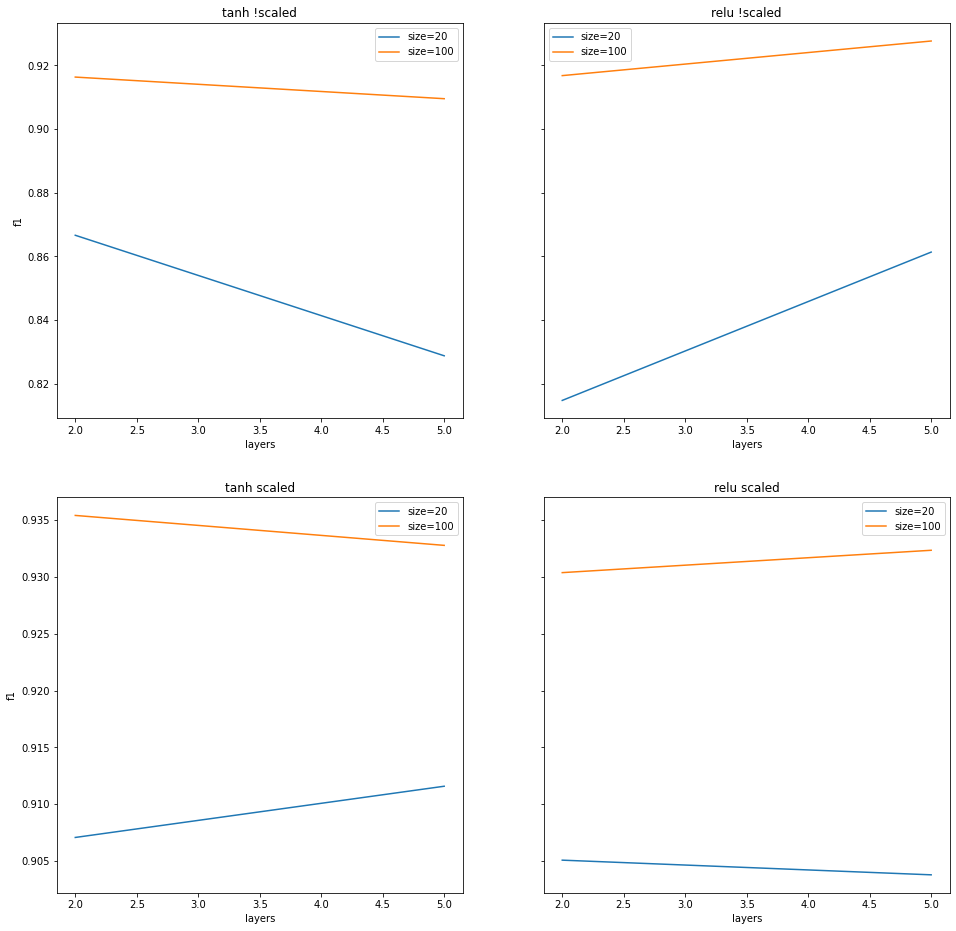

In [13]:
plot_tanh_relu_scale(df_all, "layers", "f1", ["t", "iter", "nn"])

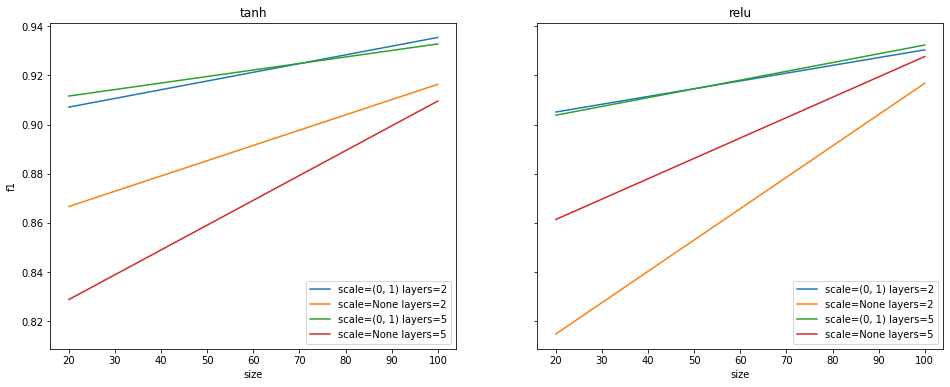

In [14]:
plot_tanh_relu(df_all, "size", "f1", ["t", "iter", "nn"])

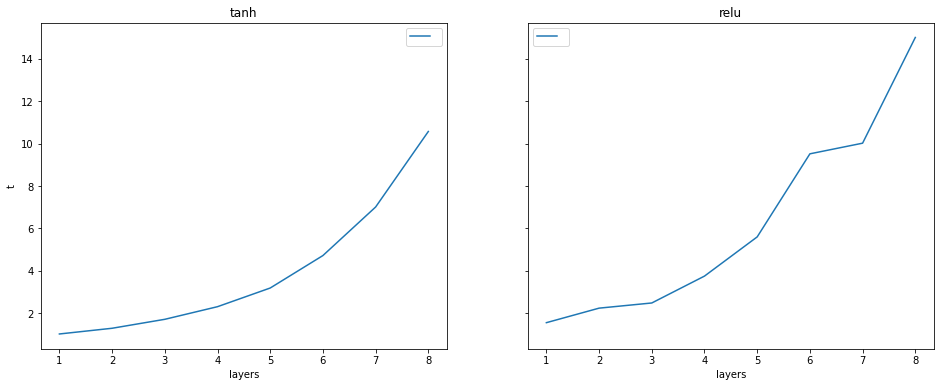

In [15]:
plot_tanh_relu(df_layers, "layers", "t", ["f1", "iter", "nn"])

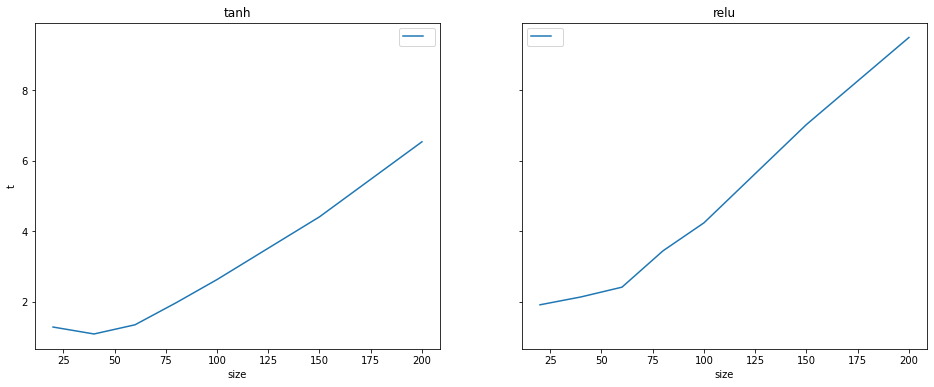

In [16]:
plot_tanh_relu(df_size, "size", "t", ["f1", "iter", "nn"])